In [821]:
import mesa
import networkx as nx
import numpy as np, pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [90]:
def compute_variance(model):
    agent_opinions = [agent.issue_positions for agent in model.schedule.agents]
    return sum(np.var(agent_opinions, axis=0))

In [870]:
class MastoAgent(mesa.Agent):
    """
    An agent posts tweets based on its issue positions with the goal of recieveing the most likes for each tweet
    The agents issue positions get updated based on the posts that recieved the most likes in the previous round

    TO IMPLEMENT
        # Bayesian updating 
        # Unidirectional Following networks
        # Retooting (boosting/retweeting)
    """

    def __init__(self, vote, confidence, unique_id, model):
        super().__init__(unique_id, model)
        self.misinfo_sensitivity = np.clip(self.model.random.normal(self.model.misinfo_sensitivity, .05), 0, 1)
        self.issue_positions = np.clip(self.model.random.normal(vote, confidence, self.model.num_issues),
                                np.zeros(self.model.num_issues), np.ones(self.model.num_issues))
        #self.confs = np.array([.0625]) # np.ones(self.model.num_issues) #np.clip(self.model.random.normal(.5, .25, self.model.num_issues),
                           #     np.zeros(self.model.num_issues), np.ones(self.model.num_issues))
        self.homefeed = []

    def generate_post(self):
        # post is generated based on issue positions and some random noise times confidence 
        post = self.issue_positions + np.var(self.issue_positions) * self.model.random.normal(0,.1,1)
        post = np.clip(post, 0, np.ones(self.model.num_issues))
        post = np.concatenate((post, np.zeros(1)), axis=0)
        return post
    
    def push_to_followers(self,post):
        # pushes a post to all the people who follow this agent
        followers = self.model.grid.get_cell_list_contents( self.model.grid.get_neighbors(self.pos) )
        for follower in followers:
            follower.homefeed.append(post)

    def check_misinfo(self,misinfo_cue):
        # True means this is misinfo and we need to reject it
        return (1 - misinfo_cue) <= np.clip(self.random.normal(self.misinfo_sensitivity, .25), 0,1) 

    def regular_update(self, true_timeline):
        true_timeline = np.array(true_timeline, ndmin=2)
        self.issue_positions = self.issue_positions + self.model.R * (1 - self.confs) * (np.mean(true_timeline[:, :-1],axis=0) - self.issue_positions)

    def bayesian_update(self, true_timeline):
        true_timeline = np.array(true_timeline, ndmin=2)
        n = true_timeline.shape[0]
        for i in range(true_timeline.shape[1]-1):
           self.issue_positions[i] = ((n/.0625)*np.mean(true_timeline[:,i].T) + self.issue_positions[i]/self.confs[i]) / (n/.0625 + 1/self.confs[i])
           self.confs[i] = 1/(n/.0625 + 1/self.confs[i])


    def updated_issue_positions(self, homefeed=False):
        feed = self.homefeed if homefeed else self.model.timeline
        
        if self.model.num_posts <= len(feed):
            timeline = np.array(feed[-self.model.num_posts:])

            # check and remove what is considered misinfo
            true_timeline = []
            for i in range(timeline.shape[0]):
                if not self.check_misinfo(timeline[i,-1]):
                    true_timeline.append(timeline[i])
                else:
                    pass
                    # some misinfo logging system (to implement)
            
            if len(true_timeline) > 0:
                #self.regular_update(true_timeline)
                self.bayesian_update(true_timeline)

            # retoot if similar opinion ?
            if False: #self.model.random.random() < 0.2:
                for i in range(true_timeline.shape[0]):
                    if np.dot(self.issue_positions, true_timeline[i, :-1])/(np.linalg.norm(self.issue_positions)*np.linalg.norm(true_timeline[i, :-1])) > .8:
                        self.model.timeline.append(true_timeline[i, :])
                        self.push_to_followers(true_timeline[i, :])
                    
                
    def step(self):
        # 1. Generate a post and add it to the timeline with probability P1
        p = self.model.random.random()
        if p <= self.model.P1:
            # Generate post based on current issue opinions
            post = self.generate_post()
            # Add it to the "local" timeline
            self.model.timeline.append(post)
            # Add it to the homefeed of all the followers of this agent
            self.push_to_followers(post)
            
        # 2. Or look at the local timeline (same for everyone) with probability P2
        elif self.model.P1 < p <= self.model.P2:
            # Update issue positions
            self.updated_issue_positions()

        # 3. Else look at the home timeline (personalized)
        else:
              # Update issue positions
            self.updated_issue_positions(homefeed=True)
            
        # Clip the issues positions to fall withing the position space     
        self.issue_positions = np.clip(self.issue_positions, np.zeros(self.model.num_issues), np.ones(self.model.num_issues))    


In [864]:
class MastoBot(mesa.Agent):
    """
   A general class for mastodon bots (ie agents that do not update their opinions and seek to inform others by posting information)
    """

    def __init__(self, issue_positions, p_misinfo, unique_id, model):
        super().__init__(unique_id, model)
        self.p_misinfo = p_misinfo
        self.issue_positions = issue_positions
            
    def generate_post(self):
        post = self.issue_positions 
        misinfo = np.clip(self.model.random.normal(self.model.misinfo_mean,.2,1), 0, 1) if self.model.random.random() <= self.p_misinfo else np.zeros(1)
        return np.concatenate((post, misinfo), axis=0)

    def step(self):
        post = self.generate_post()
        self.model.timeline.append(post)


In [857]:
class MastodonModel(mesa.Model):

    def __init__(self, N=400, ProB=50, AntiB=50, MisB=0, I=1, M= 10, S=.2, R=.1, P1=.05, P2=1, means=.55, stddevs = .2, MMean=.9, seed=None):

        self.num_agents = N # number of user/citizen agents
        self.pro_bots = ProB # number of bots with issue postion of 1 who do not use misinfo
        self.anti_bots = AntiB # number of bots with issue position of 0 who do not use misinfo
        self.misinfo_bots = MisB # number of bots with issue postion of 1 who use misinfo

        self.num_issues = I # number of issues (set to one but can be increased to generalize across situations
        self.means = means  # means of issue positions
        self.stddevs = stddevs # stds of issue positions (normal dist)
        self.num_posts = M # number of posts users see in their timelines (both local and homefeed)
        self.citizens_pro = .5*self.num_agents

        self.R = R # responsiveness to new content (ie the amount buy which you take into account new information)
        self.P1 = P1 # probability of posting by a citizen agent
        self.P2 = P2 # probability of checking ones timeline 
        self.misinfo_sensitivity = S # citizens sensitivity to misinformation (the mean of the normal with stdev .25 used in check_misinfo)
        self.timeline = [] # model-level variable for the "local" timeline (ie the timeline common to everyone)
        
        self.misinfo_mean = MMean # mean of misinformation cues (the mean of the normal with stdev .2 used in check_misinfo)

        ba = nx.barabasi_albert_graph(self.num_agents, 10, seed=None, initial_graph=None) 
        self.grid = mesa.space.NetworkGrid(ba)

        self.schedule = mesa.time.RandomActivation(self)
        self.random = np.random.default_rng(seed)
        self.running = True

        # Initializing all agents and bots 
        for i in range(self.num_agents):
            if i < self.citizens_pro:
                a = MastoAgent(1,.5, i, self)
            else:
                a = MastoAgent(0,.5, i, self)
            
            self.schedule.add(a)

            # Place agent on an empty node
            nodeid = self.random.integers(self.num_agents)
            while not self.grid.is_cell_empty(nodeid):
                nodeid = self.random.integers(self.num_agents)
            self.grid.place_agent(a, nodeid)

        for i in range(self.num_agents,self.num_agents + self.pro_bots):   
            b = MastoBot(np.ones(self.num_issues), 0, i, self)
            self.schedule.add(b)

        for i in range(self.num_agents + self.pro_bots, self.num_agents + self.pro_bots + self.anti_bots):   
            b = MastoBot(np.zeros(self.num_issues), 0, i, self)
            self.schedule.add(b)   

        for i in range(self.num_agents + self.pro_bots + self.anti_bots, self.num_agents + self.pro_bots + self.anti_bots + self.misinfo_bots):   
            b = MastoBot(np.ones(self.num_issues), 1, i, self)
            self.schedule.add(b)      

        # Logging in the data 
        self.datacollector = mesa.DataCollector(
            model_reporters={
                            "variance": compute_variance
                            },
            agent_reporters={
                            "issue_positions": "issue_positions",
                            "confs": "confs",
                            "type": type,
                           # "misinfo_sensitivity":"misinfo_sensitivity"
                            }
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [871]:
n_iters = 1
params = {
        "N":400, "ProB":50, "AntiB":50, "MisB":0,
        "MMean": .8, 
        "S": .35, #[.05, .2, .35],
        "seed": 345,
        "P1": .1,
        "R":.1
        }

results = mesa.batch_run(
    MastodonModel,
    parameters=params,
    iterations=n_iters,
    max_steps=30,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

results_df = pd.DataFrame(results)

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


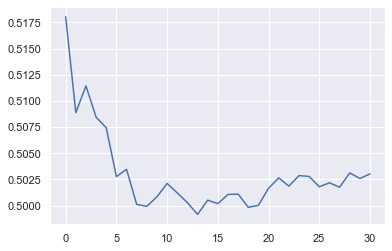

In [873]:
results2 = results_df[(results_df.RunId == 0) & (results_df.type == results_df.type[0])] 
for i in range(1):
    results2["issue1"] = results2.issue_positions.apply(lambda x: x[i])
    plt.plot(results2.groupby("Step").issue1.agg("mean"));


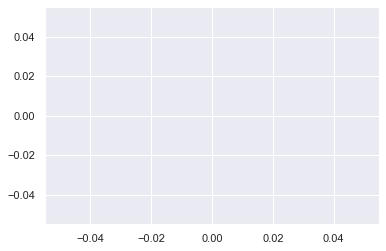

In [867]:
results2 = results_df[(results_df.RunId == 1) & (results_df.type == results_df.type[0])] 
for i in range(10):
    results2["issue1"] = results2.issue_positions.apply(lambda x: x[i]);
    plt.plot(results2.groupby("Step").issue1.agg("mean"));


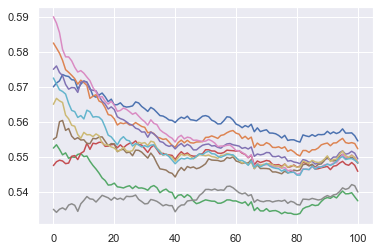

In [710]:
results2 = results_df[(results_df.RunId == 2)  & (results_df.type == results_df.type[0])] 
for i in range(10):
    results2["issue1"] = results2.issue_positions.apply(lambda x: x[i]);
    plt.plot(results2.groupby("Step").issue1.agg("mean"));

In [868]:
results2 = results_df[(results_df.RunId == 0)  & (results_df.type == results_df.type[0])] 

In [874]:
results2


,RunId,iteration,Step,N,ProB,AntiB,MisB,MMean,S,seed,P1,R,variance,AgentID,issue_positions,confs,type,issue1
0,0,0,0,400,50,50,0,0.8,0.35,345,0.1,0.1,0.082309,0,[0.47018527554541445],[0.0002090301003344482],<class '__main__.MastoAgent'>,0.470185
1,0,0,0,400,50,50,0,0.8,0.35,345,0.1,0.1,0.082309,1,[0.5887230746859493],[0.00022321428571428576],<class '__main__.MastoAgent'>,0.588723
2,0,0,0,400,50,50,0,0.8,0.35,345,0.1,0.1,0.082309,2,[0.41969329214114276],[0.00023062730627306278],<class '__main__.MastoAgent'>,0.419693
3,0,0,0,400,50,50,0,0.8,0.35,345,0.1,0.1,0.082309,3,[0.3853217671399424],[0.0002615062761506276],<class '__main__.MastoAgent'>,0.385322
4,0,0,0,400,50,50,0,0.8,0.35,345,0.1,0.1,0.082309,4,[0.6486125659722718],[0.00024038461538461543],<class '__main__.MastoAgent'>,0.648613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15395,0,0,30,400,50,50,0,0.8,0.35,345,0.1,0.1,0.050675,395,[0.5246357896983819],[0.00022563176895306855],<class '__main__.MastoAgent'>,0.524636
15396,0,0,30,400,50,50,0,0.8,0.35,345,0.1,0.1,0.050675,396,[0.4996491166158984],[0.0002394636015325671],<class '__main__.MastoAgent'>,0.499649
15397,0,0,30,400,50,50,0,0.8,0.35,345,0.1,0.1,0.050675,397,[0.4881524491831863],[0.00020764119601328907],<class '__main__.MastoAgent'>,0.488152
15398,0,0,30,400,50,50,0,0.8,0.35,345,0.1,0.1,0.050675,398,[0.5025034465916604],[0.00022321428571428576],<class '__main__.MastoAgent'>,0.502503


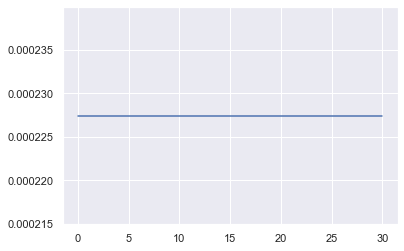

In [875]:
for i in range(1):
    plt.plot(results2.groupby("Step").confs.agg("mean"));

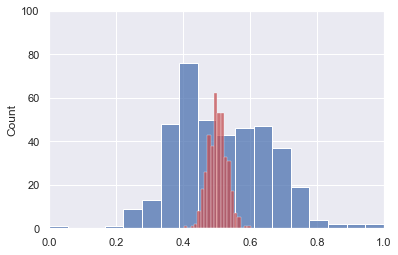

In [880]:
runid = 0
step = 1
results10 = results_df[(results_df.RunId == runid) & (results_df.Step == 0) & (results_df.type == results_df.type[0])] 
sns.histplot([float(value[0]) for value in results10.issue_positions.values], color="b")#, bins = 15) 
results10 = results_df[(results_df.RunId == 0) & (results_df.Step == 30) & (results_df.type == results_df.type[0])] 
sns.histplot([float(value[0]) for value in results10.issue_positions.values], color="r")#, bins = 15) 
plt.axis([0, 1, 0, 100]);

In [881]:
results10 = results_df[(results_df.RunId == runid) & (results_df.Step == 0) & (results_df.type == results_df.type[0])] 
values0 = [float(value[0]) for value in results10.issue_positions.values]
values0 = np.where(values0 > .5*np.ones(len(values0)), 1, 0)
results10 = results_df[(results_df.RunId == runid) & (results_df.Step == 40) & (results_df.type == results_df.type[0])] 
values1 = [float(value[0]) for value in results10.issue_positions.values]
values1 = np.where(values1 > .5*np.ones(len(values0)), 1, 0)

ValueError: operands could not be broadcast together with shapes (400,) (0,) 

In [750]:
from scipy.stats import ttest_rel
ttest_rel(values1 - values0 , values0)

Ttest_relResult(statistic=-16.0580445118342, pvalue=4.0806251270245344e-45)